In [1]:
import gymnasium as gym  # Updated from gym to gymnasium [1]
import torch
import torch.nn as nn
import numpy as np
from collections import deque
import random
from itertools import count
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter  # Updated tensorboard import [1]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Defining the DDQN Model

In [2]:
class QNetwork(nn.Module):
    def __init__(self):
        super().__init__()  # Modernized super() call [1]
        self.fc1 = nn.Linear(4, 64)
        self.fc_value = nn.Linear(64, 256)
        self.fc_adv = nn.Linear(64, 256)
        self.value = nn.Linear(256, 1)
        self.adv = nn.Linear(256, 2)

    def forward(self, state):
        y = F.relu(self.fc1(state))  # Use functional API [1]
        value = F.relu(self.fc_value(y))
        adv = F.relu(self.fc_adv(y))
        value = self.value(value)
        adv = self.adv(adv)
        adv_avg = torch.mean(adv, dim=1, keepdim=True)
        return value + adv - adv_avg

    def select_action(self, state):
        with torch.no_grad():
            q_values = self(state)  # Direct call instead of forward() [1]
            return torch.argmax(q_values).item()

class Memory(deque):  # Simplified memory implementation [1]
    def __init__(self, capacity):
        super().__init__(maxlen=capacity)
        
    def sample(self, batch_size):
        return random.sample(self, batch_size)


## Making the environment and defining the model

In [3]:
# Updated environment creation [1]
env = gym.make('CartPole-v1', render_mode=None)
n_state = env.observation_space.shape[0]

online_net = QNetwork().to(device)
target_net = QNetwork().to(device)
target_net.load_state_dict(online_net.state_dict())

optimizer = torch.optim.AdamW(online_net.parameters(), lr=1e-4)  # Modern optimizer [1]


## Training Loop

In [4]:
BATCH_SIZE = 128
UPDATE_INTERVAL = 4
GAMMA = 0.99
EPS_START = 0.1
EPS_END = 0.0001
EPS_DECAY = 20000
learning_steps = 0

memory = Memory(50000)
writer = SummaryWriter('logs/ddqn/cartpole')  # Updated tensorboard writer [1]

In [5]:
epsilon = EPS_START
episode_reward = 0

for epoch in range(350):
    state, _ = env.reset()  # Updated reset unpacking [1]
    episode_reward = 0
    
    for t in range(200):
        # Epsilon-greedy action selection
        if random.random() < epsilon:
            action = env.action_space.sample()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            action = online_net.select_action(state_tensor)
        
        # Updated step returns unpacking [1]
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        episode_reward += reward
        memory.append((state, next_state, action, reward, done))
        
        if len(memory) >= BATCH_SIZE:
            # Experience replay
            transitions = memory.sample(BATCH_SIZE)
            batch = list(zip(*transitions))
            learning_steps += 1
            
            # Update target network
            if learning_steps % UPDATE_INTERVAL == 0:
                target_net.load_state_dict(online_net.state_dict())
            
            states = torch.tensor(batch[0], dtype=torch.float32, device=device)
            next_states = torch.tensor(batch[1], dtype=torch.float32, device=device)
            actions = torch.tensor(batch[2], dtype=torch.long, device=device).unsqueeze(1)
            rewards = torch.tensor(batch[3], dtype=torch.float32, device=device).unsqueeze(1)
            dones = torch.tensor(batch[4], dtype=torch.float32, device=device).unsqueeze(1)
            
            # Double DQN update
            with torch.no_grad():
                next_actions = online_net(next_states).argmax(1, keepdim=True)
                target_q = target_net(next_states).gather(1, next_actions)
                target = rewards + (1 - dones) * GAMMA * target_q
            
            current_q = online_net(states).gather(1, actions)
            loss = F.mse_loss(current_q, target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if epsilon > EPS_END:
                epsilon -= (EPS_START - EPS_END) / EPS_DECAY
        
        
        if done:
            break
        state = next_state
            
    writer.add_scalar('episode_reward', episode_reward, epoch)
    
    if epoch % 10 == 0:
        torch.save(online_net.state_dict(), 'ddqn-policy.pt')  # Updated file extension [1]
        print(f'Epoch {epoch}: Reward {episode_reward:.2f}')


Epoch 0: Reward 10.00
Epoch 10: Reward 9.00


C:\Users\shant\AppData\Local\Temp\ipykernel_760\1037771392.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  states = torch.tensor(batch[0], dtype=torch.float32, device=device)


Epoch 20: Reward 12.00
Epoch 30: Reward 9.00
Epoch 40: Reward 8.00
Epoch 50: Reward 11.00
Epoch 60: Reward 11.00
Epoch 70: Reward 9.00
Epoch 80: Reward 10.00
Epoch 90: Reward 13.00
Epoch 100: Reward 11.00
Epoch 110: Reward 10.00
Epoch 120: Reward 10.00
Epoch 130: Reward 15.00
Epoch 140: Reward 12.00
Epoch 150: Reward 15.00
Epoch 160: Reward 13.00
Epoch 170: Reward 18.00
Epoch 180: Reward 73.00
Epoch 190: Reward 81.00
Epoch 200: Reward 111.00
Epoch 210: Reward 98.00
Epoch 220: Reward 109.00
Epoch 230: Reward 117.00
Epoch 240: Reward 173.00
Epoch 250: Reward 183.00
Epoch 260: Reward 149.00
Epoch 270: Reward 120.00
Epoch 280: Reward 161.00
Epoch 290: Reward 148.00
Epoch 300: Reward 157.00
Epoch 310: Reward 163.00
Epoch 320: Reward 189.00
Epoch 330: Reward 149.00
Epoch 340: Reward 150.00


## Plotting functions

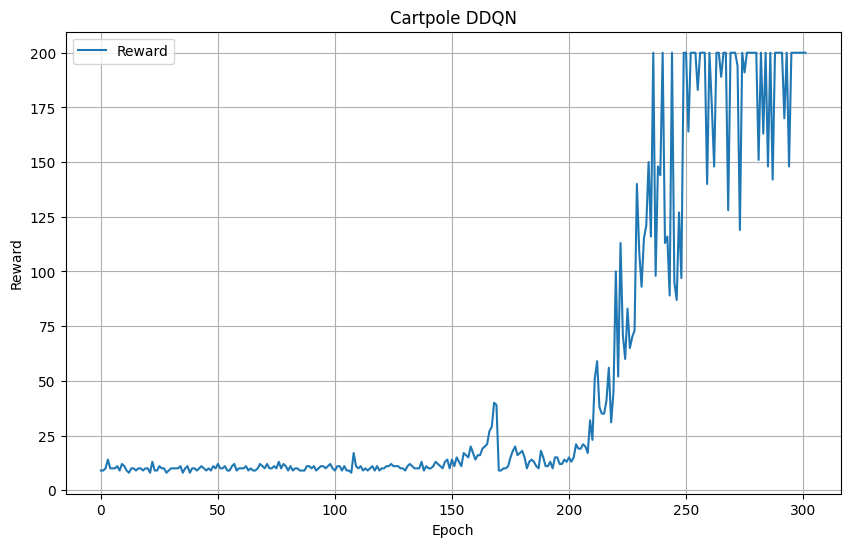

In [18]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import matplotlib.pyplot as plt

# Load the TensorBoard log data
event_acc = EventAccumulator('logs/ddqn/cartpole')
event_acc.Reload()

# Extract the reward vs. epoch data
reward_events = event_acc.Scalars('episode_reward')
epochs = [event.step for event in reward_events]
rewards = [event.value for event in reward_events]

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(range(len(rewards)), rewards, label='Reward')
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.title('Cartpole DDQN')
plt.legend()
plt.grid()
plt.show()

## Live Demo

In [20]:
# Load the trained model and render it
env = gym.make("CartPole-v1", render_mode="human")
online_net.load_state_dict(torch.load('ddqn-policy.pt'))

state, _ = env.reset()  # Updated reset unpacking [1]
    
done = False
while not done:
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action = online_net.select_action(state_tensor)
    
    # Updated step returns unpacking [1]
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    
    env.render()
    state = next_state

## Gif Maker

In [7]:
import gymnasium as gym  # Updated from gym to gymnasium [1]
import imageio
import numpy as np

env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()
frames = []

online_net.load_state_dict(torch.load('ddqn-policy.pt'))

done = False
while not done:
    # Render the current frame
    state_tensor = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action = online_net.select_action(state_tensor)
    
    # Updated step returns unpacking [1]
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    
    frame = env.render()
    frames.append(frame)
    state = next_state

env.close()

# Save frames as GIF
imageio.mimsave("cartpole2.gif", frames, fps=30)
